# Predicting temperature in San Jose, CA
The goal of this project will be to predict temperature in San Jose using various weather features. That dataset is taken from the [NOAA](https://www.ncdc.noaa.gov/data-access/quick-links#loc-clim). I will use a linear regression model as well as a KNN regression model and we evaluate which model performs better.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import helpers as hp

%matplotlib inline

## Load Dataset
Load the dataset and select columns of interest for use in this model.

In [2]:
df = pd.read_csv('./data/san_jose_weather.csv', encoding='latin')

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,43,52,71,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns.tolist()

['STATION',
 'DATE',
 'REPORT_TYPE',
 'SOURCE',
 'AWND',
 'BackupDirection',
 'BackupDistance',
 'BackupDistanceUnit',
 'BackupElements',
 'BackupElevation',
 'BackupElevationUnit',
 'BackupEquipment',
 'BackupLatitude',
 'BackupLongitude',
 'BackupName',
 'CDSD',
 'CLDD',
 'DSNW',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed',
 'DailyWeather',
 'HDSD',
 'HTDD',
 'HeavyFog',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrec

Copy `DataFrame` to a new variable to preserve the intial, raw dataset.

In [4]:
df_clean = df.copy()

Set index to _DATE_.

In [5]:
df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])
df_clean.set_index(['DATE'], inplace=True)

Only select the Daily columns and remove those columns that won't be useful in the model.

In [6]:
daily_columns = [x for x in df_clean.columns.tolist() if 'Daily' in x]
daily_columns.remove('DailyDepartureFromNormalAverageTemperature')
daily_columns.remove('DailyMaximumDryBulbTemperature')
daily_columns.remove('DailyMinimumDryBulbTemperature')
daily_columns.remove('DailyAverageWetBulbTemperature')
daily_columns.remove('DailyCoolingDegreeDays')
daily_columns.remove('DailyHeatingDegreeDays')
daily_columns.remove('DailySnowDepth')
daily_columns.remove('DailySnowfall')
daily_columns.remove('DailyWeather')
print(daily_columns)

['DailyAverageDewPointTemperature', 'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity', 'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure', 'DailyAverageWindSpeed', 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySustainedWindDirection', 'DailySustainedWindSpeed']


In [7]:
df_clean = df_clean.loc[:, daily_columns].copy()

## Data Cleaning
### Precipitation
The values in the precipitation column are strings. If there is a 'T' this indicates that there were trace amounts of precipitation. I want this column to be floats. So, I will convert each 'T' value to the minimum measurable value of '0.01' and then convert all values to floats.

In [8]:
df_clean['DailyPrecipitation'] = df_clean['DailyPrecipitation'].apply(lambda x: 0.01 if x == 'T' else float(x))

### Missing Values
Search for missing values in this dataset.

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50042 entries, 2014-01-01 00:53:00 to 2018-12-31 23:59:00
Data columns (total 11 columns):
DailyAverageDewPointTemperature    1822 non-null float64
DailyAverageDryBulbTemperature     1820 non-null float64
DailyAverageRelativeHumidity       1822 non-null float64
DailyAverageSeaLevelPressure       1821 non-null float64
DailyAverageStationPressure        1823 non-null float64
DailyAverageWindSpeed              1824 non-null float64
DailyPeakWindDirection             1807 non-null float64
DailyPeakWindSpeed                 1811 non-null float64
DailyPrecipitation                 1826 non-null float64
DailySustainedWindDirection        1825 non-null float64
DailySustainedWindSpeed            1826 non-null float64
dtypes: float64(11)
memory usage: 4.6 MB


In [10]:
print(f'Dataset length: {len(df_clean)}')
print(f'Days in dataset: {5*365}')

Dataset length: 50042
Days in dataset: 1825


This dataset is 50042 rows long, but there are only 1825 days in this time period. I will remove any empty row so as to include only daily values.

In [11]:
df_clean.dropna(inplace=True, how='all')

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2014-01-01 23:59:00 to 2018-12-31 23:59:00
Data columns (total 11 columns):
DailyAverageDewPointTemperature    1822 non-null float64
DailyAverageDryBulbTemperature     1820 non-null float64
DailyAverageRelativeHumidity       1822 non-null float64
DailyAverageSeaLevelPressure       1821 non-null float64
DailyAverageStationPressure        1823 non-null float64
DailyAverageWindSpeed              1824 non-null float64
DailyPeakWindDirection             1807 non-null float64
DailyPeakWindSpeed                 1811 non-null float64
DailyPrecipitation                 1826 non-null float64
DailySustainedWindDirection        1825 non-null float64
DailySustainedWindSpeed            1826 non-null float64
dtypes: float64(11)
memory usage: 171.2 KB


Now, I make scatter plots for each variable to visualize if there are any gaps in the data.

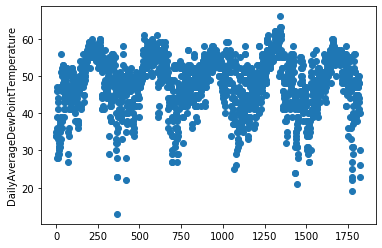

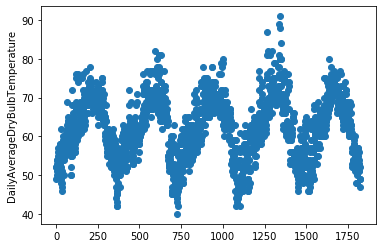

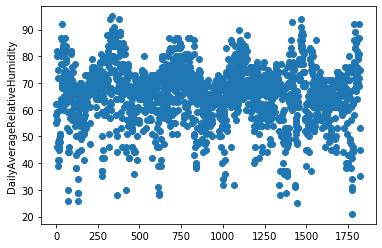

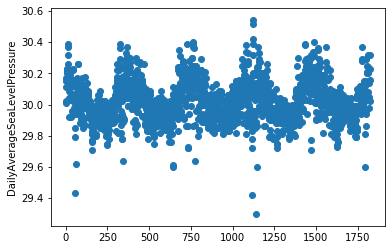

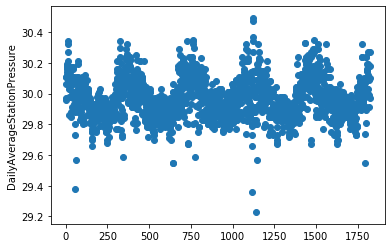

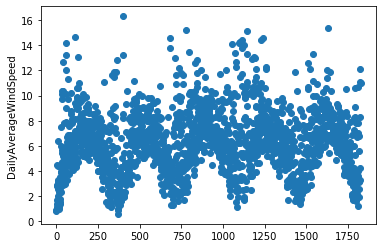

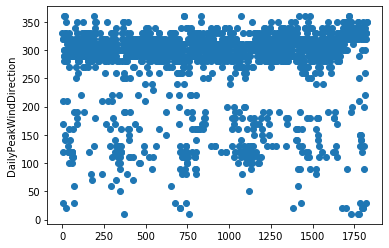

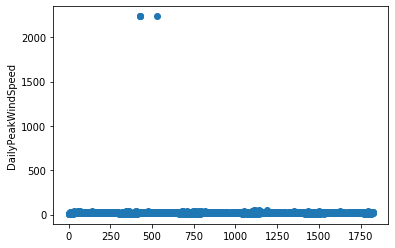

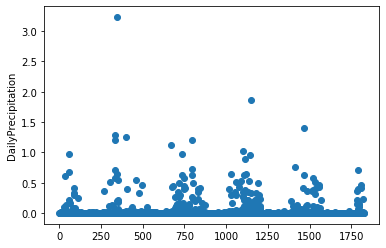

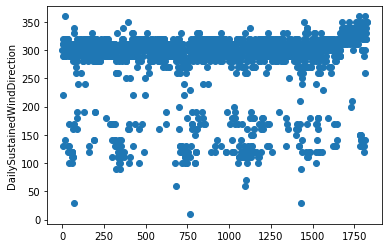

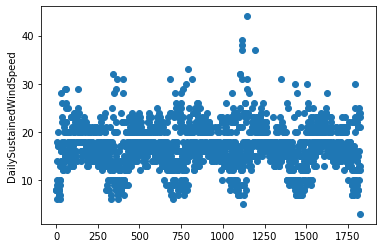

In [13]:
for column in df_clean.columns:
    plt.scatter(np.arange(len(df_clean)), df_clean[column])
    plt.ylabel(column)
    plt.show()

In [14]:
hp.find_na_columns(df_clean, display_fractions=True)

Variables and their fraction of missing values:
DailyAverageDewPointTemperature    0.002191
DailyAverageDryBulbTemperature     0.003286
DailyAverageRelativeHumidity       0.002191
DailyAverageSeaLevelPressure       0.002738
DailyAverageStationPressure        0.001643
DailyAverageWindSpeed              0.001095
DailyPeakWindDirection             0.010405
DailyPeakWindSpeed                 0.008215
DailySustainedWindDirection        0.000548
dtype: float64


**Observations:** All variables are continous. There are few large gaps in the dataset and very few missing values. I will correct for missing values using interpolation.

In [15]:
df_clean.interpolate(method='time', inplace=True)

### Outliers
I will use log() box plots to visualize the distributions for each variable and then decide how to handle the outliers.

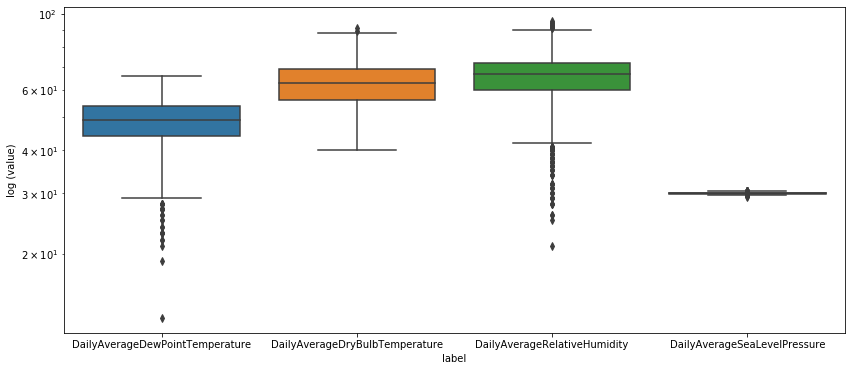

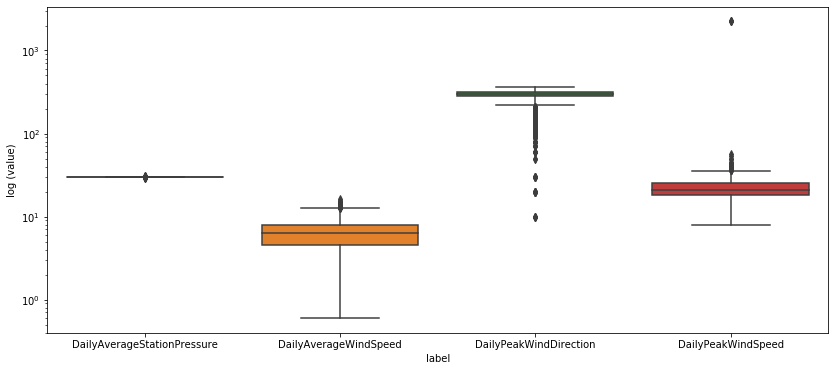

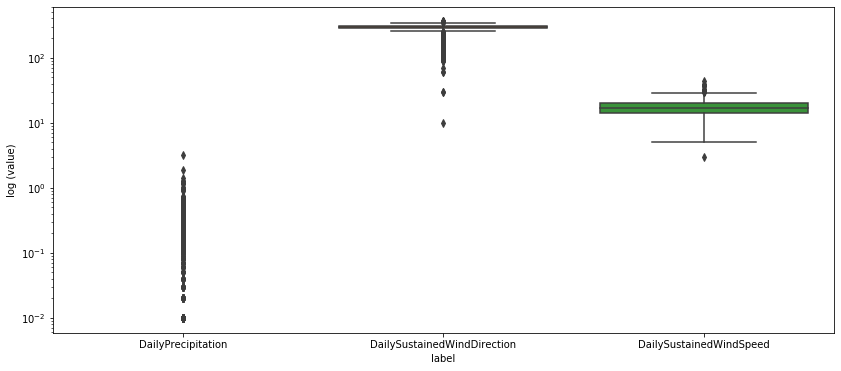

In [16]:
hp.look_for_outliers(df_clean, df_clean.columns.to_list(), max_boxes=4, log_scale=True)

### Standardize
Standardize the variables and inspect outliers again.

In [17]:
standardized_variables = [f'{x}_sd' for x in df_clean.columns]
df_clean = hp.standardize(df_clean, df_clean.columns.tolist())

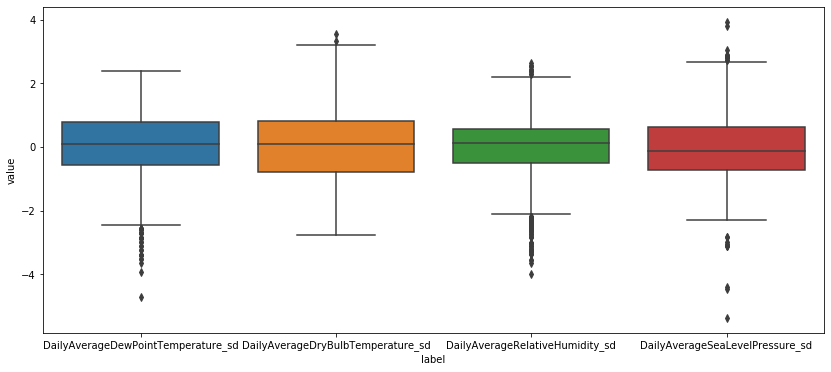

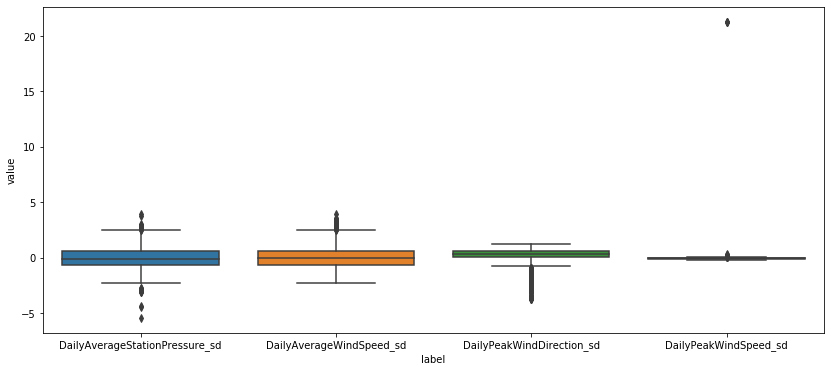

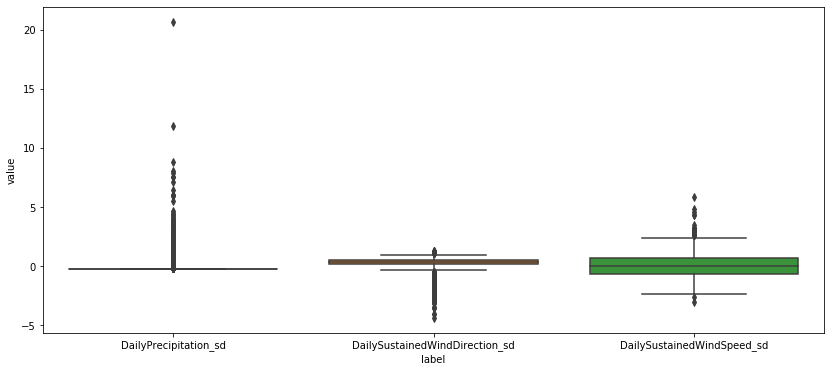

In [18]:
hp.look_for_outliers(df_clean, standardized_variables, max_boxes=4)

**Observations:**
* Wind direction is heavily skewed. This is because the wind mostly blows from the North.
    * Normalize these using Box-Cox.
* The peak wind speed has an abnormally high value.
    * Correct for this outlier.
* Daily Preciption is extremely skewed, with mostly very low values. This is because it doesn't rain much.
    * One solution would be to turn this variable into a categorical variable, saying wether it rained or not. But, since I will be using a KNN regression model, which does not perform well with one-hot-encoded categorical data, I will drop this variable.
* Other variables.
    * All other variables show some outliers. I will correct for them.

In [19]:
df_clean.drop(['DailyPrecipitation', 'DailyPrecipitation_sd'], axis=1, inplace=True)

In [20]:
standard_columns = [x for x in df_clean.columns.to_list() if '_sd' in x]

In [21]:
outlier_variables = ['DailyPeakWindSpeed_sd', 'DailyAverageDewPointTemperature_sd', 'DailyAverageDryBulbTemperature_sd',
                  'DailyAverageRelativeHumidity_sd', 'DailyAverageSeaLevelPressure_sd', 
                   'DailyAverageStationPressure_sd', 'DailySustainedWindSpeed_sd', 'DailyAverageWindSpeed_sd']

In [22]:
tk_variables = [f'{x}_tk' for x in outlier_variables]
df_clean = hp.correct_outliers(df_clean, outlier_variables)

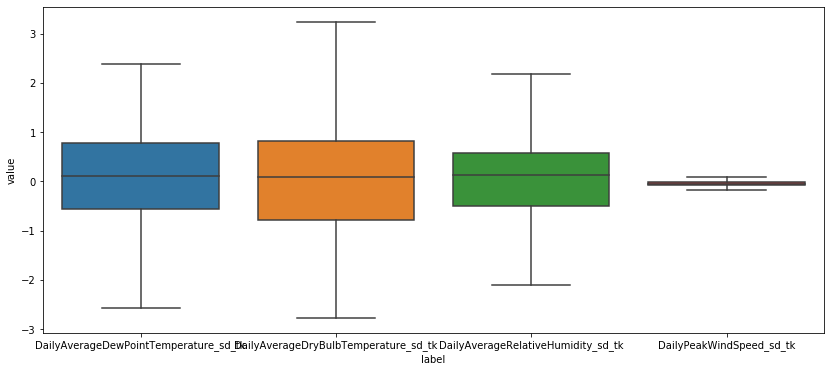

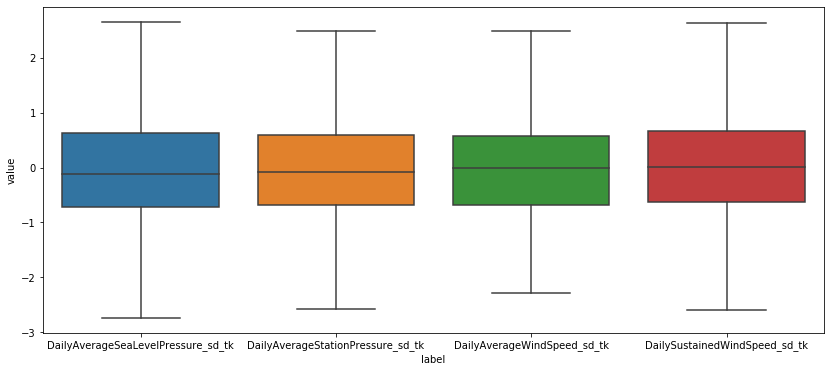

In [23]:
hp.look_for_outliers(df_clean, tk_variables, max_boxes=4)

In [24]:
transform_variables = ['DailyPeakWindDirection_sd', 'DailySustainedWindDirection_sd']
bc_variables = [f'{x}_bc' for x in transform_variables]
df_clean = hp.apply_boxcox_transform(df_clean, transform_variables)

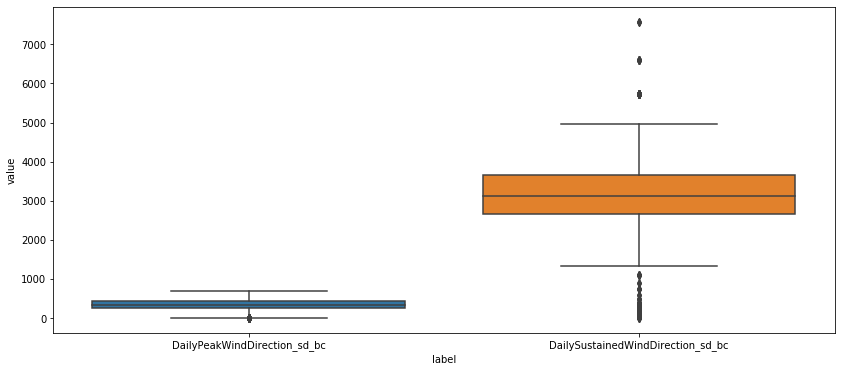

In [25]:
hp.look_for_outliers(df_clean, bc_variables, max_boxes=4)

In [26]:
model_variables = tk_variables + bc_variables

In [27]:
df_model = df_clean.loc[:, model_variables].copy()

## Data Exploration
Look for correlations between the features. The target variable is _DailyAverageDryBulbTemperature\__sd_.

In [28]:
features = ['DailyPeakWindSpeed_sd_tk',
 'DailyAverageDewPointTemperature_sd_tk',
 'DailyAverageRelativeHumidity_sd_tk',
 'DailyAverageSeaLevelPressure_sd_tk',
 'DailyAverageStationPressure_sd_tk',
 'DailySustainedWindSpeed_sd_tk',
 'DailyAverageWindSpeed_sd_tk',
 'DailyPeakWindDirection_sd_bc',
 'DailySustainedWindDirection_sd_bc']

In [29]:
df_model.loc[:, features].corr()

,DailyPeakWindSpeed_sd_tk,DailyAverageDewPointTemperature_sd_tk,DailyAverageRelativeHumidity_sd_tk,DailyAverageSeaLevelPressure_sd_tk,DailyAverageStationPressure_sd_tk,DailySustainedWindSpeed_sd_tk,DailyAverageWindSpeed_sd_tk,DailyPeakWindDirection_sd_bc,DailySustainedWindDirection_sd_bc
DailyPeakWindSpeed_sd_tk,1.000000,0.109100,-0.025106,-0.328222,-0.328757,0.925292,0.795528,-0.157133,-0.154168
DailyAverageDewPointTemperature_sd_tk,0.109100,1.000000,0.390572,-0.514956,-0.516615,0.152460,0.242258,-0.002142,-0.026537
DailyAverageRelativeHumidity_sd_tk,-0.025106,0.390572,1.000000,0.043968,0.047780,-0.024653,0.044941,-0.241607,-0.280839
DailyAverageSeaLevelPressure_sd_tk,-0.328222,-0.514956,0.043968,1.000000,0.998520,-0.349381,-0.383692,0.089962,0.085676
DailyAverageStationPressure_sd_tk,-0.328757,-0.516615,0.047780,0.998520,1.000000,-0.350315,-0.382802,0.087089,0.082417
DailySustainedWindSpeed_sd_tk,0.925292,0.152460,-0.024653,-0.349381,-0.350315,1.000000,0.792190,-0.106241,-0.119285
DailyAverageWindSpeed_sd_tk,0.795528,0.242258,0.044941,-0.383692,-0.382802,0.792190,1.000000,-0.177099,-0.178629
DailyPeakWindDirection_sd_bc,-0.157133,-0.002142,-0.241607,0.089962,0.087089,-0.106241,-0.177099,1.000000,0.731558
DailySustainedWindDirection_sd_bc,-0.154168,-0.026537,-0.280839,0.085676,0.082417,-0.119285,-0.178629,0.731558,1.000000


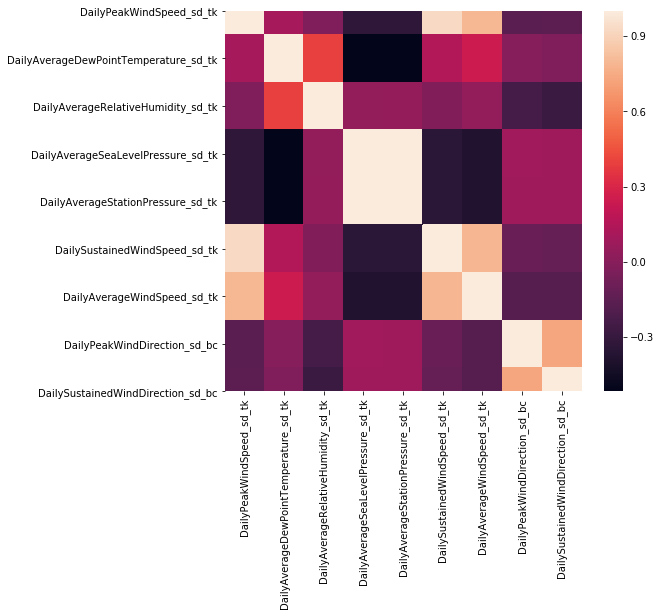

In [30]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_model.loc[:, features].corr(), ax=axes)
plt.show()

**Observations:**
* The wind speed variables are highly correlated. Just go with average wind speed and drop the rest.
* The pressure variables are highly correlated. Just go with average station pressure.

In [31]:
df_model.drop(['DailySustainedWindSpeed_sd_tk', 'DailyAverageSeaLevelPressure_sd_tk'], axis=1, inplace=True)
features.remove('DailySustainedWindSpeed_sd_tk')
features.remove('DailyAverageSeaLevelPressure_sd_tk')

Now look for correlations between the target variable, _DailyAverageDryBulbTemperature\__sd_, and the features.

In [32]:
df_model.corr()['DailyAverageDryBulbTemperature_sd_tk']

DailyPeakWindSpeed_sd_tk                 0.103466
DailyAverageDewPointTemperature_sd_tk    0.725574
DailyAverageDryBulbTemperature_sd_tk     1.000000
DailyAverageRelativeHumidity_sd_tk      -0.313935
DailyAverageStationPressure_sd_tk       -0.573796
DailyAverageWindSpeed_sd_tk              0.176475
DailyPeakWindDirection_sd_bc             0.168306
DailySustainedWindDirection_sd_bc        0.174284
Name: DailyAverageDryBulbTemperature_sd_tk, dtype: float64

**Observations:** The highest correlations with the target variable are with dew point temperature and average station pressure. All other features do not have large correlations with the target variable.

## Modeling
Split features and target and create train and test sets.

In [33]:
X = df_model.loc[:, features]
y = df_model['DailyAverageDryBulbTemperature_sd_tk']

# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Ordinary Linear Regression

In [34]:
hp.run_linear_model(LinearRegression, X_train, X_test, y_train, y_test, print_results=True)

Prediction Metrics:
* R-squared: 0.943
* MAE = 0.157
* MSE = 0.056
* RMSE = 0.236
* MAPE = 63.074%


In [35]:
hp.compare_scores()

Comparing Scores:
 * train: 0.952
 * test: 0.943


## KNN Regression

In [36]:
hp.run_knn_regressor(X_train, X_test, y_train, y_test, print_results=True)

Prediction Metrics:
* R-squared: 0.568
* MAE = 0.472
* MSE = 0.426
* RMSE = 0.653
* MAPE = 214.629%


In [37]:
hp.compare_scores()

Comparing Scores:
 * train: 0.738
 * test: 0.568


## Conclussions
Linear regression performs better than KNN regression. Linear regression has a test accuracy of 94%, while KNN regression has a test accuracy of only 57%. Also, the training accuracy for the KNN model is much larger than the test accuracy, which could indicate this model is overfitting. Furthermore, the RMSE for the KNN regression model is much larger than the RMSE value for the linear regression model.

## Future Steps
Both models have not been tuned. The linear regression model could be further improved by using regularization. Cross validation could be used with the KNN regression model to find the optimal number of neighbors for the best fit.